In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from tqdm import tqdm

### Rhombhus Dist: X + Y <= 1

In [2]:
rhombus_fn = lambda x, y: 0.5 * ((np.abs(x) + np.abs(y)) <= 1)
init_sample = (0, 0)
n_samples = 10_000
rand_step = lambda x: x + (np.random.rand() - 0.5)
proposed_generator = lambda x, y: (rand_step(x), rand_step(y))

In [3]:
def generate_single_sample(init_sample, proposed_generator, target_pdf):
    sample = proposed_generator(*init_sample)
    chance = min(1, target_pdf(*sample) / target_pdf(*init_sample))
    repeat = False

    if chance < np.random.rand():
        sample = init_sample
        repeat = True
    
    return sample, repeat


def generate_samples(n_samples, init_sample, proposed_generator, target_pdf):
    samples = []
    repeats = 0
    prev_sample = init_sample

    for _ in tqdm(range(n_samples), total=n_samples):
        sample, repeat = generate_single_sample(prev_sample, proposed_generator, target_pdf)
        if sample == prev_sample:
            repeats += repeat
        samples.append(sample)
        prev_sample = samples[-1]

    repeats_freq = repeats/n_samples
    return samples, repeats_freq

In [4]:
samples, repeats_freq = generate_samples(n_samples, init_sample, proposed_generator, rhombus_fn)

100%|██████████| 10000/10000 [00:00<00:00, 232923.72it/s]


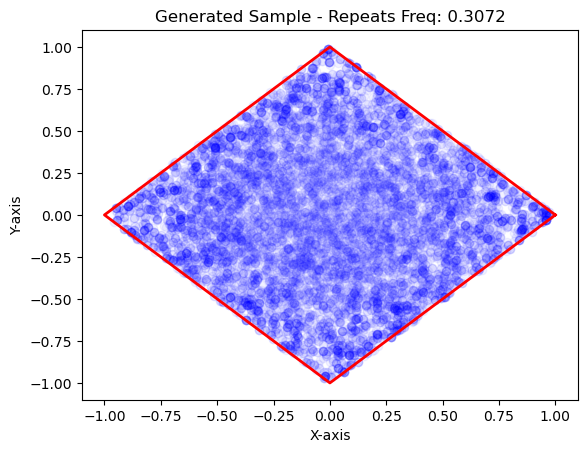

In [5]:
samples = np.array(samples)
samples_x, samples_y = samples[:,0], samples[:,1]

# Coordinates of the rhombus vertices
x = [1, 0, -1, 0, 1]
y = [0, 1, 0, -1, 0]

# Plot the rhombus edges
plt.plot(x, y, 'r-', linewidth=2)
plt.scatter(samples_x, samples_y, color='blue', marker='o', alpha=0.05)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title(f'Generated Sample - Repeats Freq: {repeats_freq}')

# Show plot
plt.show()

### Gaussian Mixture Distribution

In [6]:
weights = [0.3, 0.7]
gaussians = [(3,1.5), (-1,1)]

def gaussian_mixture_pdf(x, weights, gaussians):
    x_array = np.atleast_1d(x)
    
    pdf = np.zeros(len(x_array))
    for w, (loc, scale) in zip(weights, gaussians):
        pdf += w * st.norm.pdf(x_array, loc=loc, scale=scale)
    
    return pdf[0] if np.isscalar(x) else pdf

In [7]:
n_samples = 10_000
target_pdf = lambda x: gaussian_mixture_pdf(x, weights, gaussians)
samples_groups = []
samples_groups_freq = []
proposed_generators = {
    'normal (σ=0.5)': {'proposal': lambda x: (np.random.normal(x, 0.5), )},
    'normal (σ=1)': {'proposal': lambda x: (np.random.normal(x, 1), )},
    'normal (σ=1.5)': {'proposal': lambda x: (np.random.normal(x, 1.5), )},
    'uniform (±0.5)': {'proposal': lambda x: (np.random.uniform(x-0.5, x+0.5), )},
    'uniform (±1)': {'proposal': lambda x: (np.random.uniform(x-1, x+1), )},
    'uniform (±1.5)': {'proposal': lambda x: (np.random.uniform(x-1.5, x+1.5), )},
}
for proposed_generator_name, proposed_generator_info in proposed_generators.items():
    proposed_generator = proposed_generator_info['proposal']
    samples, repeats_freq = generate_samples(n_samples, (0, ), proposed_generator, target_pdf)
    proposed_generator_info['generated_samples'] = np.array(samples)[:,0]
    proposed_generator_info['repeats_freq'] = repeats_freq

100%|██████████| 10000/10000 [00:01<00:00, 7547.14it/s]


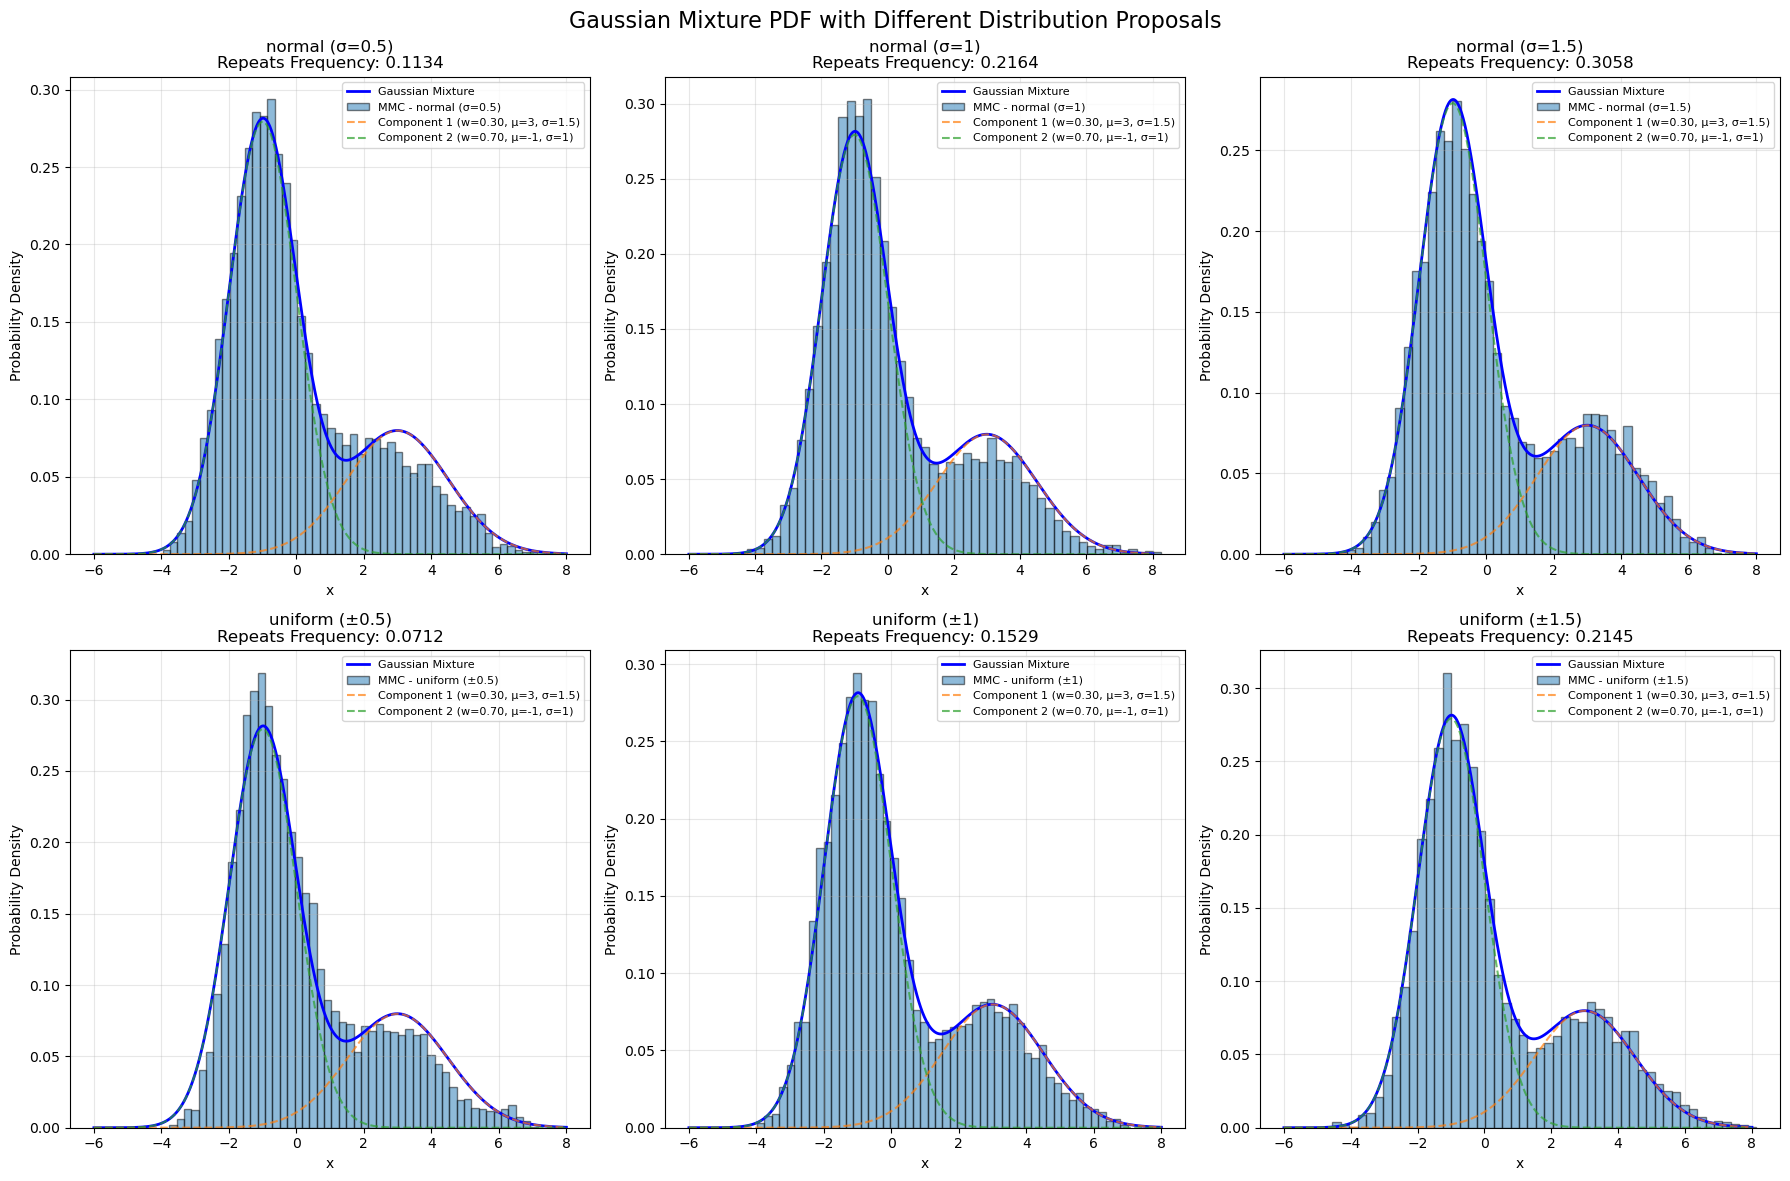

PDF value at x=-1: 0.281539


In [8]:
# Create x values for plotting
x_vals = np.linspace(-6, 8, 1000)
pdf_vals = gaussian_mixture_pdf(x_vals, weights, gaussians)

# Plot the mixture
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (proposed_generator_name, proposed_generator_info) in enumerate(proposed_generators.items()):
    ax = axes[idx]
    
    # Plot the Gaussian mixture
    ax.plot(x_vals, pdf_vals, 'b-', linewidth=2, label='Gaussian Mixture')
    
    # Get samples and frequency info
    samples = proposed_generator_info['generated_samples']
    repeats_freq = proposed_generator_info['repeats_freq']
    
    # Plot histogram of samples
    ax.hist(samples, bins=50, density=True, alpha=0.5, 
            label=f'MMC - {proposed_generator_name}', edgecolor='black')
    
    # Plot individual components
    for comp_idx, (w, (loc, scale)) in enumerate(zip(weights, gaussians)):
        component_pdf = w * st.norm.pdf(x_vals, loc=loc, scale=scale)
        ax.plot(x_vals, component_pdf, '--', alpha=0.7, 
                label=f'Component {comp_idx+1} (w={w:.2f}, μ={loc}, σ={scale})')
    
    
    # Set labels and title for each subplot
    ax.set_xlabel('x')
    ax.set_ylabel('Probability Density')
    ax.set_title(f'{proposed_generator_name}\nRepeats Frequency: {repeats_freq}')
    
    # Add legend to each subplot
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

# Add overall title
fig.suptitle('Gaussian Mixture PDF with Different Distribution Proposals', fontsize=16, y=0.98)
plt.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()

# Print the value at x=-1
y_at_minus1 = gaussian_mixture_pdf(-1, weights, gaussians)
print(f'PDF value at x=-1: {y_at_minus1:.6f}')